In [1]:
import duckdb as db
import seaborn as sns

In [2]:
conn = db.connect()
conn.sql("ATTACH 'dbname=equiv_v2 user=postgres password=herdeherde host=127.0.0.1 port=5430' as pg (TYPE POSTGRES, READ_ONLY)")

In [3]:
conn.sql("""
create or replace table rmse as
with rmse as (
  select
    t1.name as metric,
    t2.value as model,
    mean as rmse,
	step / 365 / 10 as epoch,
    t3.value as rel_pos_bias
  from
    pg.checkpoint_sample_metric_float as t1
    join pg.model_parameter_text as t2 on t1.model_id = t2.model_id
    left join pg.model_parameter_text as t3 on t1.model_id = t3.model_id
    and t3.name = 'train_config.model.config.rel_pos_bias'
  where
    t2.name = 'train_config.model.name'
    --and t3.name = 'train_config.model.config.rel_pos_bias'
)
select
  model,
  metric,
  rmse,
  epoch,
  rel_pos_bias
from
  rmse
where
metric like 'rmse%'
""")

In [4]:
conn.sql("SELECT * from rmse where model='SwinHPPangu' and rel_pos_bias='single' limit 10")

┌─────────────┬─────────────────────┬────────────────────┬────────────────────┬──────────────┐
│    model    │       metric        │        rmse        │       epoch        │ rel_pos_bias │
│   varchar   │       varchar       │       double       │       double       │   varchar    │
├─────────────┼─────────────────────┼────────────────────┼────────────────────┼──────────────┤
│ SwinHPPangu │ rmse_upper_v_50.3d  │   2.17341979061263 │ 110.05479452054794 │ single       │
│ SwinHPPangu │ rmse_upper_v_100.3d │  2.427184095433579 │ 110.05479452054794 │ single       │
│ SwinHPPangu │ rmse_upper_v_150.3d │  3.067106621938587 │ 110.05479452054794 │ single       │
│ SwinHPPangu │ rmse_upper_v_200.3d │  3.730577045550156 │ 110.05479452054794 │ single       │
│ SwinHPPangu │ rmse_upper_v_250.3d │  4.238803238980962 │ 110.05479452054794 │ single       │
│ SwinHPPangu │ rmse_upper_v_300.3d │  4.273054875922842 │ 110.05479452054794 │ single       │
│ SwinHPPangu │ rmse_upper_v_400.3d │  3.649227284

In [5]:
conn.sql("""
create or replace table data as
select
  try_cast(
    split_part(split_part(metric, '.', 1), '_', -1) as integer
  ) as pressure,
  try_cast(trim(split_part(metric, '.', 2), 'd') as integer) as days,
  string_split(split_part(metric, '.', 1), '_') [1:3] as metric,  --"min(rmse)" as min_rmse,
  *
from
  rmse
where
  (
    model = 'SwinHPPangu'
    and epoch > 101
    and epoch < 111
    and rel_pos_bias='single'
  )
  or (
    model = 'PanguParametrized'
    and epoch > 200
  )
  or (
model = 'Pangu' and epoch > 140)
""")

In [6]:
conn.sql("""
create or replace table uadata as
select
  model,
  metric,
  avg(rmse) as rmse,
  days
  --rel_pos_bias
from
  data
 where
  pressure > 50
  or pressure is null
group by
  model,
  metric,
  days,
  rel_pos_bias
""")

In [7]:
df = conn.sql("""
select
  days,
  rmse,
  CASE model
   WHEN 'SwinHPPangu' THEN 'PEAR'
   WHEN 'PanguParametrized' THEN 'Pangu'
   WHEN 'Pangu' THEN 'PanguLarge'
   ELSE model
   END as model,
  metric :: varchar as metric
from
  uadata
order by
  metric,
  model,
  days
""").df()

In [8]:
df

,days,rmse,model,metric
0,1,80.364215,PEAR,"[rmse, surface, msl]"
1,2,127.675320,PEAR,"[rmse, surface, msl]"
2,3,181.253928,PEAR,"[rmse, surface, msl]"
3,4,240.845812,PEAR,"[rmse, surface, msl]"
4,5,304.299069,PEAR,"[rmse, surface, msl]"
...,...,...,...,...
247,5,359.536367,PanguLarge,"[rmse, upper, z]"
248,6,429.807122,PanguLarge,"[rmse, upper, z]"
249,7,492.270552,PanguLarge,"[rmse, upper, z]"
250,8,544.084422,PanguLarge,"[rmse, upper, z]"


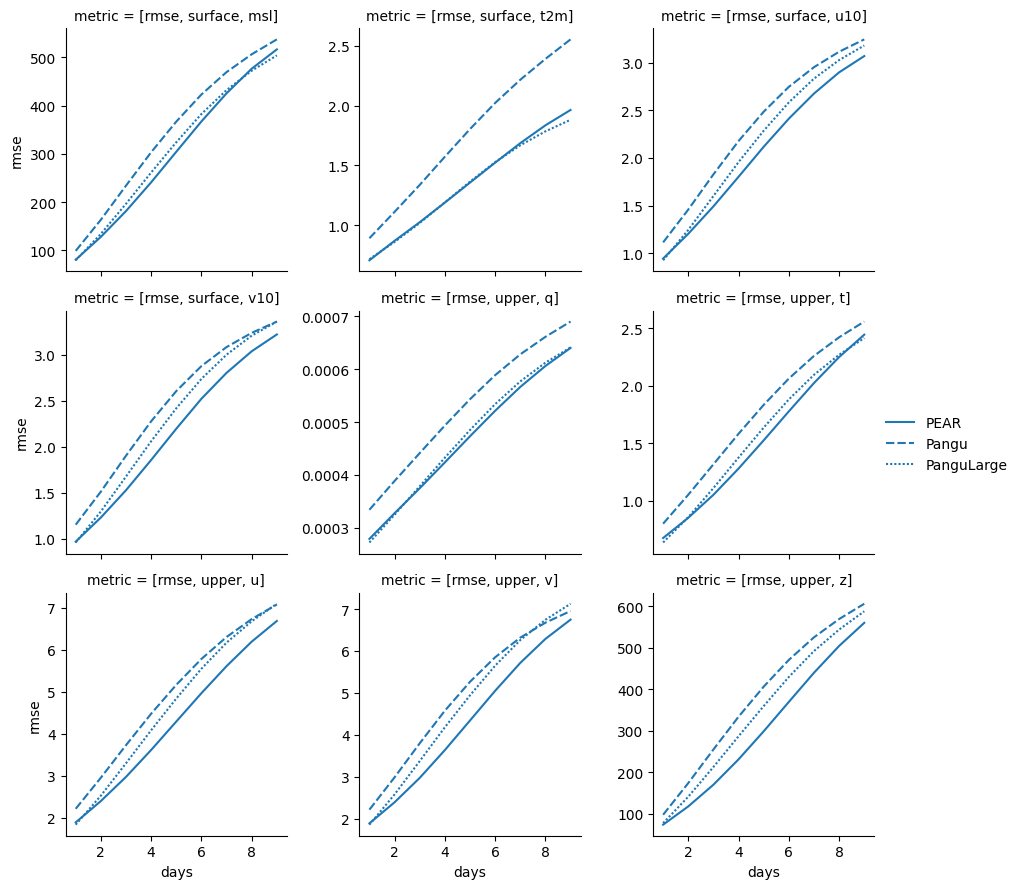

In [85]:
g = sns.FacetGrid(df, col="metric", sharey=False, col_wrap=3)
g.map_dataframe(sns.lineplot, x="days", y="rmse", style="model")
g.add_legend()
g.savefig('rmse_iterated.pdf')

In [27]:
import math, numpy as np, pandas as pd

# ── helpers ────────────────────────────────────────────────────────────────
def metric_latex(s: str) -> str:         # [acc, surface, msl] → $\mathrm{ACC}_\mathrm{surface}^\mathrm{msl}$
    p = [x.strip() for x in s.strip('[]').split(',')]
    out = '{}' #r'\mathrm{' + p[0].upper() + '}'
    if len(p) > 1: out += r'_\mathrm{' + p[1] + '}'
    if len(p) > 2: out += r'^\mathrm{' + p[2] + '}'
    return f'${out}$'

def plain_sig(v: float, sig: int = 2) -> str:      # sig-digit plain (no exp)
    digits = int(math.floor(math.log10(abs(v)))) + 1 if v else 1
    dec    = max(sig - digits, 0)
    s      = f'{v:.{dec}f}'
    return s.rstrip('0').rstrip('.') if '.' in s else s

def fmt(v: float, bold: bool) -> str:              # value → LaTeX string
    if pd.isna(v): return ''
    if v == 0:     txt = '0'
    else:
        e = int(np.floor(np.log10(abs(v))))
        txt = (f'{v/10**e:.2g}\\times 10^{{{e}}}' if e < -2        # sci  <-2
               else plain_sig(v, 2))                                # plain otherwise
    return f'$\\mathbf{{{txt}}}$' if bold else f'${txt}$'

# ── build table ─────────────────────────────────────────────────────────────
panel = df_table.copy()
panel['metric'] = panel['metric'].map(metric_latex)

pivot = (panel
         .pivot_table(index=['metric', 'days'],
                      columns='model',
                      values='rmse')
         .reindex(columns=['PEAR', 'Pangu', 'PanguLarge']))

min_mask = pivot[['PEAR', 'Pangu']].eq(pivot[['PEAR', 'Pangu']].min(axis=1),
                                       axis=0)

fmt_tbl = pivot.copy()
for col in fmt_tbl.columns:
    bold_col = min_mask[col] if col in min_mask else [False]*len(fmt_tbl)
    fmt_tbl[col] = [fmt(v, b) for v, b in zip(pivot[col], bold_col)]

latex = fmt_tbl.to_latex(#hrules=True,
                         column_format='l'*pivot.index.nlevels + 'rr|r') \
               .replace(r'\_', '_')                       # keep math underscores

# insert \midrule between different metrics and drop any \cline lines
out, first = [], True
for ln in latex.splitlines():
    if ln.lstrip().startswith(r'\cline'):
        continue
    if ln.lstrip().startswith(r'\multirow'):
        if not first: out.append(r'\midrule')
        first = False
    out.append(ln)

print('\n'.join(out))


\begin{tabular}{llrr|r}
\toprule
 & model & PEAR & Pangu & PanguLarge \\
metric & days &  &  &  \\
\midrule
\multirow[t]{3}{*}{${}_\mathrm{surface}^\mathrm{msl}$} & 1 & $\mathbf{80}$ & $99$ & $79$ \\
 & 3 & $\mathbf{181}$ & $234$ & $196$ \\
 & 5 & $\mathbf{304}$ & $367$ & $324$ \\
\midrule
\multirow[t]{3}{*}{${}_\mathrm{surface}^\mathrm{t2m}$} & 1 & $\mathbf{0.71}$ & $0.89$ & $0.72$ \\
 & 3 & $\mathbf{1}$ & $1.3$ & $1$ \\
 & 5 & $\mathbf{1.4}$ & $1.8$ & $1.4$ \\
\midrule
\multirow[t]{3}{*}{${}_\mathrm{surface}^\mathrm{u10}$} & 1 & $\mathbf{0.94}$ & $1.1$ & $0.93$ \\
 & 3 & $\mathbf{1.5}$ & $1.8$ & $1.6$ \\
 & 5 & $\mathbf{2.1}$ & $2.5$ & $2.3$ \\
\midrule
\multirow[t]{3}{*}{${}_\mathrm{surface}^\mathrm{v10}$} & 1 & $\mathbf{0.97}$ & $1.2$ & $0.96$ \\
 & 3 & $\mathbf{1.5}$ & $1.9$ & $1.7$ \\
 & 5 & $\mathbf{2.2}$ & $2.6$ & $2.4$ \\
\midrule
\multirow[t]{3}{*}{${}_\mathrm{upper}^\mathrm{q}$} & 1 & $\mathbf{2.8\times 10^{-4}}$ & $3.3\times 10^{-4}$ & $2.7\times 10^{-4}$ \\
 & 3 & $\mathbf

In [30]:
import math, numpy as np, pandas as pd

# ── helpers ──────────────────────────────────────────────────────────
def num_tex(v, bold):
    if pd.isna(v): txt = ''
    elif v == 0:   txt = '0'
    else:
        e = int(np.floor(np.log10(abs(v))))
        txt = (f'{v/10**e:.2g}\\times 10^{{{e}}}' if e < -2  # sci only for < 10⁻²
               else f'{v:.2g}')
    return f'$\\mathbf{{{txt}}}$' if bold else f'${txt}$'

# ── table without metric/day columns ─────────────────────────────────
pivot = (df_table
         .pivot_table(index=['metric', 'days'], columns='model', values='rmse'))

cols_main  = [c for c in ['PEAR', 'Pangu'] if c in pivot]   # main pair
cols_extra = [c for c in pivot.columns if c not in cols_main]
pivot = pivot[cols_main + cols_extra]

min_mask = pivot[cols_main].eq(pivot[cols_main].min(axis=1), axis=0)
bold = pd.DataFrame(False, index=pivot.index, columns=pivot.columns)
bold[cols_main] = min_mask

rows, cur_metric = [], None
for (m, d), vals in pivot.iterrows():
    if m != cur_metric:                    # separate metric blocks
        if cur_metric is not None:
            rows.append(r'\midrule')
        cur_metric = m
    rows.append(
        ' & '.join(num_tex(vals[c], bold.at[(m, d), c]) for c in pivot.columns) +
        r' \\'
    )

# ── print LaTeX ─────────────────────────────────────────────────────
bar = '|' if cols_extra else ''
print(r'\begin{tabular}{' + 'r'*len(cols_main) + bar + 'r'*len(cols_extra) + '}')
print(r'\toprule')
print(' & '.join(cols_main + cols_extra) + r' \\')
print(r'\midrule')
print('\n'.join(rows))
print(r'\bottomrule')
print(r'\end{tabular}')


\begin{tabular}{rr|r}
\toprule
PEAR & Pangu & PanguLarge \\
\midrule
$\mathbf{80}$ & $99$ & $79$ \\
$\mathbf{1.8e+02}$ & $2.3e+02$ & $2e+02$ \\
$\mathbf{3e+02}$ & $3.7e+02$ & $3.2e+02$ \\
\midrule
$\mathbf{0.71}$ & $0.89$ & $0.72$ \\
$\mathbf{1}$ & $1.3$ & $1$ \\
$\mathbf{1.4}$ & $1.8$ & $1.4$ \\
\midrule
$\mathbf{0.94}$ & $1.1$ & $0.93$ \\
$\mathbf{1.5}$ & $1.8$ & $1.6$ \\
$\mathbf{2.1}$ & $2.5$ & $2.3$ \\
\midrule
$\mathbf{0.97}$ & $1.2$ & $0.96$ \\
$\mathbf{1.5}$ & $1.9$ & $1.7$ \\
$\mathbf{2.2}$ & $2.6$ & $2.4$ \\
\midrule
$\mathbf{2.8\times 10^{-4}}$ & $3.3\times 10^{-4}$ & $2.7\times 10^{-4}$ \\
$\mathbf{3.7\times 10^{-4}}$ & $4.4\times 10^{-4}$ & $3.8\times 10^{-4}$ \\
$\mathbf{4.7\times 10^{-4}}$ & $5.4\times 10^{-4}$ & $4.8\times 10^{-4}$ \\
\midrule
$\mathbf{0.68}$ & $0.8$ & $0.64$ \\
$\mathbf{1.1}$ & $1.3$ & $1.1$ \\
$\mathbf{1.5}$ & $1.8$ & $1.6$ \\
\midrule
$\mathbf{1.9}$ & $2.2$ & $1.8$ \\
$\mathbf{3}$ & $3.7$ & $3.3$ \\
$\mathbf{4.3}$ & $5.2$ & $4.8$ \\
\midrule
$\mathbf